In [18]:
# import necessary library
import numpy as np

# Henry Gas Solubility Optimization

class HGSO:
    def __init__(self):
        self.l1 = 5e-2
        self.l2 = 100
        self.l3 = 1e-2
        self.maximum_optimization = 1
        self.t0 = 298.15
        self.K = 1
        self.epsilon = 0.05
        self.c1 = 0.1
        self.c2 = 0.2
        self.compiled = 0
        self.population = None
        self.fitnesses = None
        self.X_best = None
        self.Xi_best = None
        self.best_fitness = None
        self.history=[]

    def compile(self, obj, lb, ub, dimension, max_iter=100, population_size=100, n_cluster=5, alpha=1.0, beta=1.0, optimization="maximize"):
        if population_size % n_cluster != 0:
            raise Exception("Number of search agent in each cluster shoudl be same")
        self.dim = dimension
        self.lb = lb
        self.ub = ub
        self.alpha = alpha
        self.beta = beta
        self.n_population = population_size
        self.n_cluster = n_cluster
        self.optimization = optimization
        self.comp_id = 0 if optimization == "maximize" else -1
        self.obj = obj
        self.compiled = 1
        self.max_iter = max_iter

    def __get_fitness(self, X):
        if self.optimization == "maximize":
            return self.obj(X)
        elif self.optimization == "minimize":
            return 1 / (self.obj(X) + 0.002)

    def __initialize_population(self, dim, n_population, n_cluster):
        population = np.random.uniform(self.lb, self.ub, size=(self.n_population, self.dim))
        fitness = []
        for x in population:
            fitness.append(self.__get_fitness(x))
        return population, np.array(fitness)

    def __initialize_constant(self, n_population, n_cluster):
        h_j = (self.l1 * np.random.uniform(0, 1, n_cluster)).reshape(-1, 1)
        C_j = (self.l3 * np.random.uniform(0, 1, n_cluster)).reshape(-1, 1)
        n_j = n_population // n_cluster
        P_ij = self.l2 * np.random.uniform(0, 1, size=(n_cluster, n_j))
        return h_j, C_j, P_ij

    def __get_cluster_best(self, population_fitness, n_cluster):
        n_element = self.n_population // n_cluster
        cluster_best = []

        for i in range(n_cluster):
            li = i * n_element
            ui = li + n_element
            best = np.argsort(population_fitness[li:ui])[-1]
            cluster_best.append(i * n_element + best)
        return np.array(cluster_best)

    def __get_population_best(self, population_fitness):
        return self.__get_cluster_best(population_fitness, 1)

    def __update_h_j(self, max_iter, t):
        T = t / max_iter
        h_j = self.h_j * np.exp(-self.C_j * ((1.0 / T) - (1.0 / self.t0)))

        return h_j

    def __update_S_ij(self, h_j, P_ij):
        S_ij = self.K * h_j * P_ij

        return S_ij

    def __update_worst_agent(self):
        # Getting the value of N_w
        N_w = int(self.n_population * (np.random.uniform(0, self.c2 - self.c1) + self.c1))
        # Getting the index of worst agent in the population

        worst_pop_index = np.argsort(self.fitnesses)[:N_w]
        # print(f"N_w: {N_w}")
        # Updating the worst agent in the population
        self.population[worst_pop_index] = np.random.uniform(self.lb, self.ub, size=(N_w, self.dim))
        # Updating the fitnesses of newly assigned agent
        for i in worst_pop_index:
            self.fitnesses[i] = self.__get_fitness(self.population[i])

    def __update_global_best(self):
        best_id = self.__get_population_best(self.fitnesses)
        #print(best_id)
        if self.best_fitness == None or self.best_fitness < self.fitnesses[best_id]:
            self.X_best = self.population[best_id]
            self.best_fitness = self.fitnesses[best_id]

    def __update_population(self):
        # Setting the F value according to a random number to make the update diverse
        F = []
        for i in range(self.n_population):
            f = -1 if np.random.uniform() < 0.5 else 1
            F.append(f)
        F = np.array(F).reshape(-1, 1)
        # print(F.shape)
        # print("Hello World")

        # r is a random value
        r = np.random.uniform(0, 1, size=(self.n_population, 1))

        # Getting the number of population in a clusters
        n_cluster_population = self.n_population // self.n_cluster

        # Getting the best search agent in cluster and best agent in the whole population
        X_best = self.X_best
        Xi_best = self.population[self.Xi_best].repeat(n_cluster_population, axis=0)

        # Getting the value of constant  gamma
        epsilon = 0.05
        best_fitnesses = self.fitnesses[self.Xi_best].repeat(n_cluster_population)

        gamma = self.beta * np.exp(-(best_fitnesses + self.epsilon) / (self.fitnesses + self.epsilon))
        gamma = gamma.reshape(-1, 1)
        updated_population = self.population * F * r * gamma * (Xi_best - self.population) + F * r * self.alpha * (
                    self.S_ij.reshape(-1, 1) * X_best + self.population)
        updated_population = np.clip(updated_population, self.lb, self.ub)
        # print(gamma.shape)
        fitnesses = []
        for i in updated_population:
            fitnesses.append(self.__get_fitness(i))
        return updated_population, np.array(fitnesses)
    
    def get_history(self):
        return self.history

    def train(self):
        # Checking if compiled
        if self.compiled == 0:
            raise Exception("You have to compile first.")
        # Initializing the population and cluster, calculating the fitness of the populations
        self.population, self.fitnesses = self.__initialize_population(self.dim, self.n_population, self.n_cluster)

        # Intializing the Necessary constant
        self.h_j, self.C_j, self.P_ij = self.__initialize_constant(self.n_population, self.n_cluster)
        # Getting the fitness and getting the best gasses in the clusters and in the swarm

        # Getting the index of best search agent in population and clusters
        # self.X_best = self.__get_population_best(self.fitnesses)
        # self.Xi_best = self.__get_cluster_best(self.fitnesses,self.n_cluster)

        for i in range(self.max_iter):
            # Evaluating the current populations using fitnesses
            self.__update_global_best()

            self.Xi_best = self.__get_cluster_best(self.fitnesses, self.n_cluster)

            # Updating the Henry Gas Constant for each cluster
            self.h_j = self.__update_h_j(self.max_iter, i + 1)

            # Updating the solubility of the gas
            self.S_ij = self.__update_S_ij(self.h_j, self.P_ij)
            self.population, self.fitnesses = self.__update_population()

            # Updating the position of worst agent in the population
            self.__update_worst_agent()
            #print(f"Best Agent: {self.X_best}\t Best Value: {self.best_fitness}")
            self.history.append(self.best_fitness.tolist()[0])
        return (self.X_best,self.best_fitness)


# Sine Cosine Optimization Algorithm
class SineCosineOptimization():
    def __init__(self):
        self.history=[]
    
    def get_history(self):
        return self.history

    def compile(self, obj, dimension, lb, ub, a=2, population_size=100, max_iter=100, optimization="maximize"):
        self.objective_function = obj
        self.dimension = dimension
        self.lb = lb
        self.ub = ub
        self.a = a
        self.max_iter = max_iter
        self.optimization = optimization
        self.population_size = population_size

    def __initialize_population(self, population_size, dim, lb, ub):
        return lb + np.random.rand(population_size, dim) * (ub - lb)

    def __update_R(self, current_iter, max_iter, a):
        r1 = a - a * (current_iter / max_iter)
        r2 = 2 * np.pi * np.random.rand()
        r3 = np.random.rand()
        r4 = np.random.rand()

        return r1, r2, r3, r4

    def __update_population(self, populations, fittest_candidate, r1, r2, r3, r4, lb, ub):
        if r4 < 0.5:
            populations = populations + r1 * np.sin(r2) * np.abs(r3 * fittest_candidate - populations)
        else:
            populations = populations + r1 * np.cos(r2) * np.abs(r3 * fittest_candidate - populations)

        return np.clip(populations, lb, ub)

    def train(self):

        # Initialize the variable for  fittest candidate
        fittest_candidate = None
        candidate_evaluations = np.empty([self.population_size])

        # Initialize the random population
        populations = self.__initialize_population(self.population_size, self.dimension, self.lb, self.ub)

        ## This is the iteration loop.
        for i in range(self.max_iter):

            ## This loop will go through the all population of candidate and process them one by one
            for j in range(populations.shape[0]):
                candidate_evaluations[j] = self.objective_function(populations[j, :])

            ## Determining the fittest candidate
            if self.optimization == "maximize":
                fittest_indice = np.argmax(candidate_evaluations)
            elif self.optimization == "minimize":
                fittest_indice = np.argmin(candidate_evaluations)

            ## Updating the fittest candidate

            if fittest_candidate == None:
                fittest_candidate = (populations[fittest_indice, :], candidate_evaluations[fittest_indice])
            else:
                current_fittest = (populations[fittest_indice, :], candidate_evaluations[fittest_indice])
                if self.optimization == "maximize" and fittest_candidate[1] < current_fittest[1]:
                    fittest_candidate = current_fittest

                if self.optimization == "minimize" and fittest_candidate[1] > current_fittest[1]:
                    fittest_candidate = current_fittest

            ## Updating the value of r1,r2,r3, and r4
            r1, r2, r3, r4 = self.__update_R(i, self.max_iter, self.a)

            ## Update the population
            populations = self.__update_population(populations, fittest_candidate[0], r1, r2, r3, r4, self.lb, self.ub)
            self.history.append(fittest_candidate[1])
        return fittest_candidate

## Butterfly Optimization Algorithm
class ButterflyOptimization():
    def __init__(self):
        self.objective_function = None
        self.history = []
    
    def get_history(self):
        return self.history

    def compile(self, obj, dimension, lb, ub, c=0.5, p=0.8, population_size=100, max_iter=100,
                          optimization="maximize"):
        self.objective_function = obj
        self.dimension = dimension
        self.lb = lb
        self.ub = ub
        self.c = c
        self.p = p
        self.max_iter = max_iter
        self.optimization = optimization
        self.population_size = population_size

    ## Initialize the populations of butterfly randomly
    def __initialize_population(self):
        return self.lb + np.random.rand(self.population_size, self.dimension) * (self.ub - self.lb)

    ## Calculate the fragrance using the formula f=c*I^2
    def __calculate_fragrance(self, I, a):
        return self.c * np.power(I, a)

    ## This function will find the best butterfly in a specific iteration
    def __find_best_butterfly(self, populations, I):
        if self.optimization == "maximize":
            return np.array(populations[np.argmax(I)]), np.max(I)
        elif self.optimization == "minimize":
            return np.array(populations[np.argmin(I)]), np.min(I)
        else:
            raise Exception(f"Unknown Optimization Criteria: {self.optimization}")

    ## This function will update the global best butterfly
    def __update_global_best_butterfly(self, global_best, current_best):
        if global_best == None:
            return current_best

        if self.optimization == "maximize":
            return current_best if current_best[1] >= global_best[1] else global_best
        elif self.optimization == "minimize":
            return current_best if current_best[1] <= global_best[1] else global_best

    ## This is the population update function:
    ## if r < p:
    ## next_population = current_population + (r^2*best_butterfly-current_population)*fragrance
    ## else:
    ## next_population_i = current_population_i + (r^2*current_population_j-current_population_k)*fragrance

    def __update_population(self, current_population, best_butterfly, F):
        r = np.random.rand(self.population_size, 1)
        j = current_population.copy()
        k = current_population.copy()

        np.random.shuffle(j)
        np.random.shuffle(k)

        next_population_rlp = current_population + (r ** 2 * best_butterfly - current_population) * np.expand_dims(F,
                                                                                                                   axis=1)
        next_population_rgp = current_population + (r ** 2 * j - k) * np.expand_dims(F, axis=1)
        r = r < self.p
        next_population = r * next_population_rlp + (1 - r) * next_population_rgp
        return np.clip(next_population, self.lb, self.ub)

    def train(self):
        if self.objective_function == None:
            raise Exception("You should compile first.")
        global_best = None
        population = self.__initialize_population()
        a = np.random.rand()

        for i in range(self.max_iter):
            ## Calculate the value of stimulus intensity I
            I = np.array([self.objective_function(j) for j in population])

            ## Calculate the frangrance
            F = self.__calculate_fragrance(I, a)

            ## Get the best index of best butterfly from populations
            best_butterfly = self.__find_best_butterfly(population, I)

            global_best = self.__update_global_best_butterfly(global_best, best_butterfly)

            ## Update the populations
            populations = self.__update_population(population, global_best[0], F)

            a = np.random.rand()
            self.c += 0.025 / (self.c * self.max_iter)
            self.history.append(global_best[1])
        return global_best

## Owl Search Optimization

class OwlOptimization():
    def __init__(self):
        self.history=[]
    
    def get_history(self):
        return self.history

    def compile(self, obj, dimension, lb, ub, population_size=100, max_iter=100, optimization="maximize"):
        self.objective_function = obj
        self.dimension = dimension
        self.lb = lb
        self.ub = ub
        self.max_iter = max_iter
        self.optimization = optimization
        self.population_size = population_size

    def __initialize_population(self, owl_num, dim, lb, ub):
        return lb + np.random.uniform(0, 1, size=(owl_num, dim)) * (ub - lb)

    def __normalization_intensity(self, fitness_of_owl):
        # Find minimun and maximum value
        b_max = np.amax(fitness_of_owl, axis=-1)[..., np.newaxis]
        w_min = np.amin(fitness_of_owl, axis=-1)[..., np.newaxis]

        # Return normalization intensity of owl position by equation 4
        return (fitness_of_owl - w_min) / (b_max - w_min)

    def __prey_distance(self, owl_info, prey_info):
        return np.linalg.norm(owl_info - prey_info, axis=-1)

    def __change_intensity_owl_loc(self, intensity_owl_loc, distance_info_R):

        return ((intensity_owl_loc) / (distance_info_R ** 2 + 0.02)) + np.random.normal(0, 1)

    def __linearly_dec_constant(self, crnt, max_num, range_min=0, range_max=1.9):
        return (crnt - range_min) / (max_num - range_min) * range_max

    def __update_owl_loc(self, alpha, beta, owl_locations, prey_loc_v, intensity_ICi):

        # Generate random number 0 to 1
        pvm = np.random.uniform(0, 1)

        if pvm < 0.5:
            return owl_locations + beta * intensity_ICi * np.absolute(alpha * prey_loc_v - owl_locations)
        else:
            return owl_locations - beta * intensity_ICi * np.absolute(alpha * prey_loc_v - owl_locations)

    def train(self):

        # Get Owl with initial locatins
        owl_loc_with_dim = self.__initialize_population(self.population_size, self.dimension, self.lb, self.ub)

        # Print n * d matrix
        # print(f"Matrix for number of owl with search space:\n\n{owl_loc_with_dim}")

        # Initialize the variable for  fittest candidate
        fittest_owl_V = None
        candidate_evaluations = np.empty([self.population_size])
        # Normalization intensity of owl position
        intensity_owl_loc = self.__normalization_intensity(owl_loc_with_dim)
        for i in range(self.max_iter):

            # Calculating the output of objective function
            for j in range(self.population_size):
                candidate_evaluations[j] = self.objective_function(owl_loc_with_dim[j, :])

            ## Determining the fittest candidate
            if self.optimization == "maximize":
                fittest_idx = np.argmax(candidate_evaluations)
            elif self.optimization == "minimize":
                fittest_idx = np.argmin(candidate_evaluations)

            ## Updating the fittest candidate
            if fittest_owl_V == None:
                fittest_owl_V = (owl_loc_with_dim[fittest_idx, :], candidate_evaluations[fittest_idx])
            else:
                current_fittest = (owl_loc_with_dim[fittest_idx, :], candidate_evaluations[fittest_idx])

                if self.optimization == "maximize" and fittest_owl_V[1] < current_fittest[1]:
                    fittest_owl_V = current_fittest

                if self.optimization == "minimize" and fittest_owl_V[1] > current_fittest[1]:
                    fittest_owl_V = current_fittest

            # Calculate prey distance
            distance_info_R = self.__prey_distance(owl_loc_with_dim, fittest_owl_V[0])[..., np.newaxis]

            # Now change intensity for ith owl
            intesity_Ici = self.__change_intensity_owl_loc(intensity_owl_loc, distance_info_R)

            alpha = np.random.uniform(0, 0.5)
            beta = self.__linearly_dec_constant((self.population_size - i), self.population_size)
            owl_loc_with_dim = self.__update_owl_loc(alpha, beta, owl_loc_with_dim, fittest_owl_V[0], intesity_Ici)
            self.history.append(fittest_owl_V[1])

        return fittest_owl_V




In [19]:
import numpy as np
# f1


class Sphere():
    def __init__(self, dim, opt_value):
        self.dim = dim
        self.opt_value = opt_value
        self.optimization = 'minimize'

    def get_algorithm(self):
        def sphere_func(x):
            res = 0
            for i in x:
                res += i**2
            return res
        return sphere_func
# f2


class Schwefel_2_22():
    def __init__(self, dim, opt_value):
        self.dim = dim
        self.opt_value = opt_value
        self.optimization = 'minimize'

    def get_algorithm(self):
        def schwefel_2_22_func(x):
            # Summation of xi
            sum = 0
            for item in x:
                sum += item
            # Product of xi
            prod = 1
            for item in x:
                prod *= item
            res = sum + prod
            return res
        return schwefel_2_22_func
# f3


class Schwefel_1_2():
    def __init__(self, dim, opt_value):
        self.dim = dim
        self.opt_value = opt_value
        self.optimization = 'minimize'

    def get_algorithm(self):
        def schwefel_1_2_func(x):
            res = 0
            for item in range(len(x)):
                temp = 0
                for j in range(item+1):
                    temp += x[j]
                    res += temp**2
            return res
        return schwefel_1_2_func
# f5


class Rosenbrock():
    def __init__(self, dim, opt_value):
        self.dim = dim
        self.opt_value = opt_value
        self.optimization = 'minimize'

    def get_algorithm(self):
        def rosenbrock_func(x):
            res = 0
            for i in range(len(x)-1):
                xi = x[i]
                xi_plus_1 = x[i + 1]
                xi_squared = xi ** 2
                term1 = 100 * (xi_plus_1 - xi_squared) ** 2
                term2 = (xi - 1) ** 2
                res += term1 + term2
            return res
        return rosenbrock_func

# f6


class Step():
    def __init__(self, dim, opt_value):
        self.dim = dim
        self.opt_value = opt_value
        self.optimization = 'minimize'

    def get_algorithm(self):
        def step_func(x):
            res = 0
            for i in x:
                res += (i + 0.5) ** 2
            return res
        return step_func

# f7


class Quartic_with_noise():
    def __init__(self, dim, opt_value):
        self.dim = dim
        self.opt_value = opt_value
        self.optimization = 'minimize'

    def get_algorithm(self):
        def quartic_with_noise_func(x):
            res = 0
            for i in range(len(x)):
                res += ((i+1)*(x[i]) ** 4) + np.random.rand()
            return res
        return quartic_with_noise_func

# f8
class Ackley():
    def __init__(self, dim, opt_value):
        self.dim = dim
        self.opt_value = opt_value
        self.optimization = 'minimize'

    def get_algorithm(self):
        def ackley_func(x):
            res = -20*np.exp(-0.2*np.sqrt(1/len(x)*sum(i**2 for i in x))) - \
                np.exp(1/len(x)*sum(np.cos(2*np.pi*i) for i in x))+20+np.exp(1)
            return res
        return ackley_func

In [10]:
# Import necessary libraray
import numpy as np
#from Benchmark import Sphere,Schwefel_2_22,Schwefel_1_2,Rosenbrock,Step,Quartic_with_noise
#from Algorithms import HGSO, SineCosineOptimization, OwlOptimization, ButterflyOptimization

## Set Necessary Variable
dim = 30
epoches = 100
lb = np.array([-100]).repeat(dim)
ub = np.array([100]).repeat(dim)
optimization = "minimize"
n_population = 100

##Benchmark Algorithms
Algorithms = [{"algorithm":Sphere(dim,0),"name":"Sphere"},{"algorithm":Schwefel_2_22(dim,0),"name":"Schwefel_2_22"},
              {"algorithm":Schwefel_1_2(dim,0),"name":"Schwefel_1_2"},{"algorithm":Rosenbrock(dim,0),"name":"Rosenbrock"},
              {"algorithm":Step(dim,0),"name":"Step"},{"algorithm":Quartic_with_noise(dim,0),"name":"Quartic_with_Noise"}]

## Optimizers list
optimizers = [HGSO,SineCosineOptimization,OwlOptimization,ButterflyOptimization]
optimizers_name = ['HGSO', "Sine Cosine Optimizer", "Owl Search Optimizer", "Buttefly Optimizer"]

#defining dimension
lbs = [[-100],[-10],[-100],[-30],[-100],[-100]]
ubs = [[100],[10],[100],[30],[100],[100]]

## Creating the helper function

def get_benchmark(optimizer):
    for i in range(len(Algorithms)):
        opt = optimizer()
        algo = Algorithms[i]
        lb = np.array(lbs[i]).repeat(dim)
        ub = np.array(ubs[i]).repeat(dim)
        opt.compile(obj=algo["algorithm"].get_algorithm(),population_size=n_population,dimension=dim,lb=lb,ub=ub,max_iter=epoches,optimization=optimization)
        value = opt.train()[1]
        print(f"Benchmark: {algo['name']}\t value:{value}")

opt_index = 0
print(f"Optimizer: {optimizers_name[opt_index]}")
get_benchmark(optimizers[opt_index])

Optimizer: HGSO
Benchmark: Sphere	 value:[500.]


<ipython-input-6-5b0d689129d6>:129: RuntimeWarning: overflow encountered in exp
  gamma = self.beta * np.exp(-(best_fitnesses + self.epsilon) / (self.fitnesses + self.epsilon))


Benchmark: Schwefel_2_22	 value:[61286.33334689]
Benchmark: Schwefel_1_2	 value:[500.]
Benchmark: Rosenbrock	 value:[0.03477268]
Benchmark: Step	 value:[4.96354179]
Benchmark: Quartic_with_Noise	 value:[0.10258387]


In [29]:
dim=30
max_iter = 50
population_size=300
lb = np.array([-35]).repeat(dim)
ub = np.array([35]).repeat(dim)

[500.]
0.1898180764972402


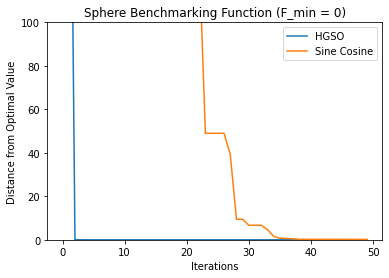

In [43]:
dim=30
max_iter = 50
population_size=300
lb = np.array([-100]).repeat(dim)
ub = np.array([100]).repeat(dim)
sphere = Sphere(dim,0)

## HGSO
hgso = HGSO()
hgso.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
print(hgso.train()[1])
hgso_history=hgso.get_history()

## Sine Cosine Algorithm

sinecosine= SineCosineOptimization()
sinecosine.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
print(sinecosine.train()[1])
sinecosine_history=sinecosine.get_history()
## Butterfly Optimization
#butterfly = ButterflyOptimization()
#butterfly.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
#print(butterfly.train()[1])
#butterfly_history=butterfly.get_history()

##  OwlOptimization
#owl = OwlOptimization()
#owl.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
#print(owl.train()[1])
#owl_history=hgso.get_history()
#print(owl_history)

## Visualize
import matplotlib.pyplot as plt
plt.title("Sphere Benchmarking Function (F_min = 0)")
plt.plot(1/np.array(hgso_history),label="HGSO")
plt.plot(sinecosine_history,label="Sine Cosine")
#plt.plot(butterfly_history,label="Butterfly Optimization")
#plt.plot(owl_history,label="Owl Search Optimization")
plt.xlabel("Iterations")
plt.ylabel("Distance from Optimal Value")
plt.legend()
plt.ylim(0,100)
plt.show()

[500.]
0.029807600972273196


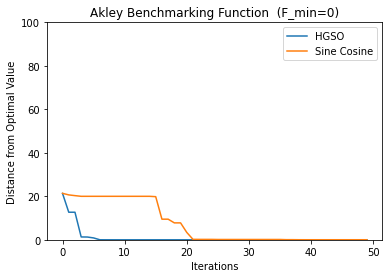

In [42]:
dim=30
max_iter = 50
population_size=300
lb = np.array([-100]).repeat(dim)
ub = np.array([100]).repeat(dim)
sphere = Ackley(dim,0)

## HGSO
hgso = HGSO()
hgso.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
print(hgso.train()[1])
hgso_history=hgso.get_history()

## Sine Cosine Algorithm

sinecosine= SineCosineOptimization()
sinecosine.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
print(sinecosine.train()[1])
sinecosine_history=sinecosine.get_history()
## Butterfly Optimization
#butterfly = ButterflyOptimization()
#butterfly.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
#print(butterfly.train()[1])
#butterfly_history=butterfly.get_history()
#print(butterfly_history)

##  OwlOptimization
#owl = OwlOptimization()
#owl.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
#print(owl.train()[1])
#owl_history=hgso.get_history()
#print(owl_history)

## Visualize
import matplotlib.pyplot as plt
plt.title("Akley Benchmarking Function  (F_min=0)")
plt.plot(1/np.array(hgso_history),label="HGSO")
plt.plot(sinecosine_history,label="Sine Cosine")
#plt.plot(butterfly_history,label="Butterfly Optimization")
#plt.plot(owl_history,label="Owl Search Optimization")
plt.xlabel("Iterations")
plt.ylabel("Distance from Optimal Value")
plt.legend()
plt.ylim(0,100)
plt.show()

In [ ]:
dim=30
max_iter = 50
population_size=300
lb = np.array([-100]).repeat(dim)
ub = np.array([100]).repeat(dim)
sphere = Sphere(dim,0)

## HGSO
hgso = HGSO()
hgso.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
print(hgso.train()[1])
hgso_history=hgso.get_history()

## Sine Cosine Algorithm

sinecosine= SineCosineOptimization()
sinecosine.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
sinecosine_history=sinecosine.get_history()

## Butterfly Optimization
butterfly = ButterflyOptimization()
butterfly.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
butterfly_history=butterfly.get_history()

##  OwlOptimization
owl = OwlOptimization()
owl.compile(sphere.get_algorithm(),population_size=population_size,dimension=dim,lb=lb,ub=ub,max_iter=max_iter,optimization="minimize")
owl_history=hgso.get_history()

## Visualize
import matplotlib.pyplot as plt
plt.plot(1/np.array(hgso_history),label="HGSO")
plt.plot(sinecosine_history,label="Sine Cosine")
plt.plot(butterfly_history,label="Butterfly Optimization")
plt.plot(owl_history,label="Owl Search Optimization")
plt.xlabel("Iterations")
plt.ylabel("Distance from Optimal Value")
plt.legend()
plt.show()


In [92]:
print(history0)

[0.04851969620418407, 1.0691037837495871, 1.9807882180482344, 117.51320578374714, 467.6751638283979, 493.9176816986975, 495.13050381844613, 499.40092884047925, 499.52001838580446, 499.72345095182726, 499.7624635364805, 499.94517192795496, 499.97757249442765, 499.98578789536487, 499.9992381127197, 499.99972219026813, 499.9999346299658, 499.99998433064576, 499.99998433064576, 499.9999986791677, 499.99999874578106, 499.99999971656007, 499.9999999990008, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889, 499.999999999889]


In [26]:
import matplotlib.pyplot as plt

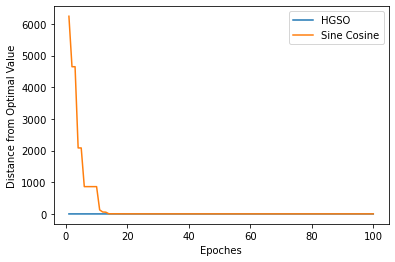

In [28]:
plt.plot(np.arange(1,101),1/np.array(history0),label="HGSO")
plt.plot(np.arange(1,101),history1,label="Sine Cosine")
plt.xlabel("Epoches")
plt.ylabel("Distance from Optimal Value")
plt.legend()
plt.show()

In [94]:
a = 1/499.99999999889

In [95]:
print(a)

0.00200000000000444
